# Pick sample and visualize

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from IPython.display import display
from ipyfilechooser import FileChooser
import os
from data_utils.helpers import visualize_pointcloud

# Create and display a FileChooser widget
fc = FileChooser('/home/hoang/Dataset/')
# Set a file filter patern
fc.filter_pattern = '*.txt'
display(fc)

# Print the selected filename
print(fc.selected_filename)

FileChooser(path='/home/hoang/Dataset', filename='', title='', show_hidden=False, select_desc='Select', change…

None


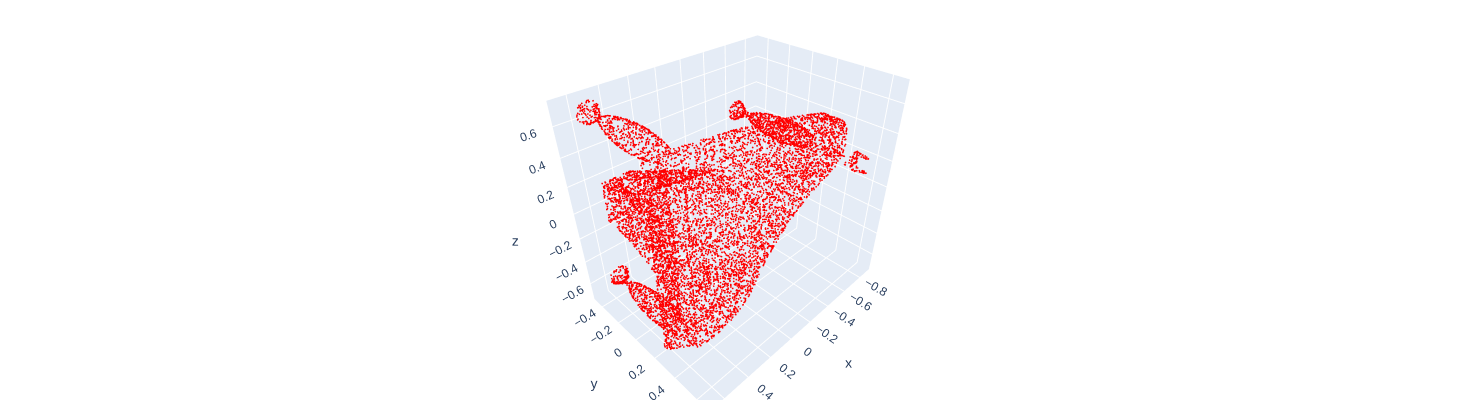

In [17]:
sample_points_path = os.path.join(fc.selected_path, fc.selected_filename)
visualize_pointcloud(sample_points_path, stride=1)

# Run model prediction

This model is trained with these hyperparams:

```
batch_size=32
num_category=42
epoch=200
num_point=6000
optimizer='Adam'
learning_rate=0.001
decay_rate=0.0001
```

Model training results:
Achieves 93.69% Test Accuracy


![](log/classification/pointnet2_cls_ssg_normal_42c/trainresults.png)

In [4]:
MODEL_NAME = 'pointnet2_cls_ssg'
CKPT_PATH = 'log/classification/pointnet2_cls_ssg_normal_42c/checkpoints/best_model.pth'
NUM_CLASS = 42
USE_NORMALS = True

In [34]:
import importlib
import sys
import torch
from torchsummary import summary

# import model class
sys.path.append(os.path.join('models'))
checkpoint = torch.load(CKPT_PATH)

# get model by number of classes (categories)
model = importlib.import_module(MODEL_NAME)
classifier = model.get_model(NUM_CLASS, normal_channel=USE_NORMALS)

# load pretrained weights
classifier.load_state_dict(checkpoint['model_state_dict'])
classifier = classifier.eval()

# use summary to view model structure
summary(classifier, (6, 5000), col_names=['input_size', 'output_size', 'num_params', 'kernel_size']) # (xyzn, num_points)
None

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
├─PointNetSetAbstraction: 1-1            [-1, 3, 5000]             [-1, 3, 512]              --                        --
|    └─ModuleList: 2                     []                        []                        --                        --
|    |    └─Conv2d: 3-1                  [-1, 6, 32, 512]          [-1, 64, 32, 512]         448                       [6, 64, 1, 1]
|    └─ModuleList: 2                     []                        []                        --                        --
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 512]         [-1, 64, 32, 512]         128                       [64]
|    └─ModuleList: 2                     []                        []                        --                        --
|    |    └─Conv2d: 3-3                  [-1, 64, 32, 512]         [-1, 64, 32, 512]         4,160                     [64,

In [7]:
with open('data/modelnet40_withFootLast/modelnet40_shape_names.txt', 'r') as file:
    CLASSES = file.read().split()

print("# Classes:", len(CLASSES))
print(', '.join(CLASSES))

# Classes: 42
piano, bottle, bench, wardrobe, cup, night_stand, keyboard, curtain, lamp, tent, stairs, bookshelf, sofa, tv_stand, dresser, flower_pot, range_hood, monitor, toilet, laptop, vase, cone, door, radio, bathtub, desk, mantel, guitar, plant, car, airplane, person, table, foot, glass_box, sink, stool, chair, bed, last, xbox, bowl


In [21]:
import torch
import numpy as np
from data_utils.ModelNetDataLoader import pc_normalize

# read sample point cloud data into numpy array for prediction
points = np.loadtxt(sample_points_path, delimiter=',')
points[:, 0:3] = pc_normalize(points[:, 0:3]) # Normalize

# Prediction
with torch.no_grad():
    inputs = torch.tensor(points, dtype=torch.float)[None,].transpose(1,2) # Put on tensor
    logits, _ = classifier(inputs) # Get logits
    pred_idx = logits.data.max(1)[1].item()
    pred = CLASSES[pred_idx]
    
print("Model prediction:", pred.upper())

Model prediction: PIANO
